## Data Visualizations and Analysis

Available datasets:
- Realised_Supply_Germany.csv
- Realised_Demand_Germany.csv
- Weather_Data_Germany.csv

### Realised Supply Germany

In [45]:
import pandas as pd
import numpy as np

from pathlib import Path


In [46]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

df.head()

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75
2,01.01.19 00:30,01.01.19 00:45,"1.204,50",381.25,"791,75","5.213,50",0,31.5,"2.246,00","1.555,25","648,5","804,75",44,431.25
3,01.01.19 00:45,01.01.19 01:00,"1.208,75",381.00,"754,5","5.308,25",0,31.5,"2.241,75","1.459,00","597,5","796,5",41,431.50
4,01.01.19 01:00,01.01.19 01:15,"1.204,50",388.25,"715,5","5.398,50",0,31.5,"2.224,50","1.367,75","610,5","765,5",21,429.25


In [47]:
# Convert columns to numeric, replacing commas and handling errors
df["Wind Offshore [MW]"] = df["Wind Offshore [MW] "].str.replace('.', '', regex=False)
df["Wind Offshore [MW]"] = df["Wind Offshore [MW]"].str.replace(',', '.', regex=False).astype(float)

df["Wind Onshore [MW]"] = df["Wind Onshore [MW]"].str.replace('.', '', regex=False)
df["Wind Onshore [MW]"] = df["Wind Onshore [MW]"].str.replace(',', '.', regex=False).astype(float)

In [48]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Date from                140256 non-null  object 
 1   Date to                  140256 non-null  object 
 2   Biomass [MW]             140256 non-null  object 
 3   Hydro Power [MW]         140256 non-null  float64
 4   Wind Offshore [MW]       140256 non-null  object 
 5   Wind Onshore [MW]        140256 non-null  float64
 6   Solar Power [MW]         140256 non-null  object 
 7   Other Renewable [MW]     140256 non-null  float64
 8   Nuclear Power [MW]       140256 non-null  object 
 9   Lignite [MW]             140256 non-null  object 
 10  Coal [MW]                140256 non-null  object 
 11  Natural Gas [MW]         140256 non-null  object 
 12  Pumped Storage [MW]      140256 non-null  object 
 13  Other Conventional [MW]  140256 non-null  float64
 14  Wind

,Hydro Power [MW],Wind Onshore [MW],Other Renewable [MW],Other Conventional [MW],Wind Offshore [MW]
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,415.334046,2801.744943,41.626820,360.720734,713.154145
std,93.873992,2257.499037,9.004413,50.798691,479.952273
min,209.500000,22.750000,12.500000,131.750000,0.000000
25%,343.750000,1056.500000,34.750000,328.500000,269.000000
50%,404.750000,2109.250000,41.000000,365.500000,672.750000
75%,485.750000,4007.250000,49.000000,393.750000,1143.750000
max,685.000000,11045.000000,60.250000,577.000000,1815.500000


<Axes: title={'center': 'Wind [MW]'}>

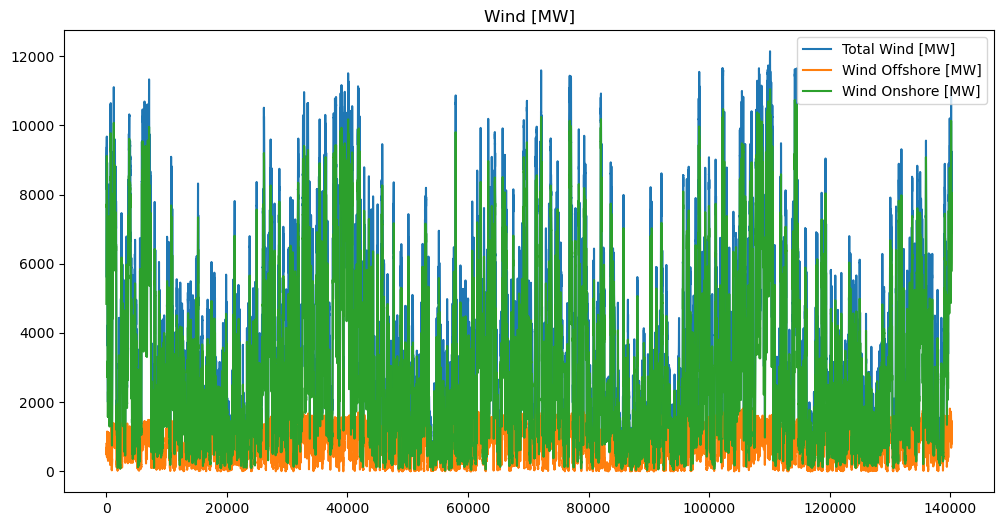

In [49]:

# Calculate the sum of Wind Offshore and Wind Onshore
df['Total Wind [MW]'] = df['Wind Offshore [MW]'] + df['Wind Onshore [MW]']

# Plot the data
df[["Total Wind [MW]", "Wind Offshore [MW]", "Wind Onshore [MW]"]].plot(
    figsize=(12, 6), title="Wind [MW]"
)